In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [2]:
import numpy as np

import keras
import tensorflow as tf 
from keras.layers import Conv2D, Dense
from keras.layers import concatenate, add
from keras.layers import BatchNormalization, Activation, PReLU, LeakyReLU
from keras.layers import Input, Flatten, UpSampling2D
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
import keras.backend as K
from keras.applications.vgg19 import VGG19

from time import time
from shutil import rmtree

from batch_generator import COCOBatchGenerator
from bsd100_callback import BSD100_evaluate
from utils import print_available_devices, deprocess_HR, deprocess_LR

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [3]:
if tf.test.is_built_with_cuda():
    data_format = 'channels_first'
    keras.backend.set_image_data_format('channels_first')
else:
    data_format = 'channels_last'
    keras.backend.set_image_data_format('channels_last')

In [4]:
print("Keras : ", keras.__version__)
print("\t data_format : ", keras.backend.image_data_format())
print("Tensorflow : ", tf.__version__)
print_available_devices()

Keras :  2.1.6
	 data_format :  channels_first
Tensorflow :  1.8.0
Device : /device:CPU:0
	 type : CPU
	 desc :

Device : /device:GPU:0
	 type : GPU
	 desc :device: 0, name: GeForce GTX 1070, pci bus id: 0000:02:00.0, compute capability: 6.1



## Parameters

In [5]:
B = 16 # number of residual block

batch_size = 16
target_size = (96,96)
downscale_factor = 4

# axis used in Parametric ReLU !
shared_axis = [1,2] if data_format == 'channels_last' else [2,3]

# axis for Batch Normalization
axis = -1 if data_format == 'channels_last' else 1

## Build the Generator

In [6]:
# build a residual block
def res_block(inputs):
    x = Conv2D(64, kernel_size=(3,3), strides=(1,1), padding='same', activation=None, use_bias=False)(inputs)
    x = BatchNormalization(axis=axis)(x)
    x = PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=shared_axis)(x)
    x = Conv2D(64, kernel_size=(3,3), strides=(1,1), padding='same', activation=None, use_bias=False)(x)
    x = BatchNormalization(axis=axis)(x)
    return add([x, inputs])

# build an upscale block
# PixelShuffler is replaced by an UpSampling2D layer (nearest upsampling)

def up_block(x):
    x = Conv2D(256, kernel_size=(3,3), strides=(1,1) , padding='same', activation=None, use_bias=False)(x)
    x = UpSampling2D(size=(2, 2))(x)
    x = PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=shared_axis)(x)
    return x

In [7]:
input_generator = Input(shape=(None, None, 3) if data_format=='channels_last' else (3, None, None), 
                        name='input_generator')

x = Conv2D(filters=64, kernel_size=(9,9),
           strides=(1,1), padding='same',
           activation=None)(input_generator)

x_input_res_block = PReLU(alpha_initializer='zeros',
                          alpha_regularizer=None,
                          alpha_constraint=None,
                          shared_axes=shared_axis)(x)

x = x_input_res_block

# add B residual blocks 
for i in range(B):
    x = res_block(x)

x = Conv2D(64, kernel_size=(3,3), strides=(1,1), padding='same', activation=None, use_bias=False)(x)
x = BatchNormalization(axis=axis)(x)

# skip connection
x = add([x, x_input_res_block])

# two upscale blocks
x = up_block(x)
x = up_block(x)

# final conv layer : activated with tanh -> pixels in [-1, 1]
output_generator = Conv2D(3, kernel_size=(9,9), 
                          strides=(1,1), activation='tanh',
                          use_bias=False, padding='same')(x)

generator = Model(inputs=input_generator, outputs=output_generator)

In [ ]:
pretrained_weights = 'checkpoints/SRResNet-MSE/best_weights.hdf5'
generator.load_weights(pretrained_weights)

## Build the Discriminator

In [8]:
def conv_block(x, filters, kernel_size, strides):
    x = Conv2D(filters, kernel_size=kernel_size, strides=strides,
               activation=None, use_bias=False, padding='same')(x)
    x = BatchNormalization(axis=axis)(x)
    x = LeakyReLU(alpha=0.2)(x)
    return x

In [9]:
input_discriminator = Input(shape=target_size+(3,) if data_format=='channels_last' else (3,)+target_size, 
                            name='input_discimintaor')

x = Conv2D(64, kernel_size=(3,3), strides=(1,1), use_bias=False,
           activation=None, padding='same')(input_discriminator)
x = LeakyReLU(alpha=0.2)(x)

x = conv_block(x, filters=64, kernel_size=(4,4), strides=(2,2))
x = conv_block(x, filters=128, kernel_size=(3,3), strides=(1,1))
x = conv_block(x, filters=128, kernel_size=(4,4), strides=(2,2))
x = conv_block(x, filters=256, kernel_size=(3,3), strides=(1,1))
x = conv_block(x, filters=256, kernel_size=(4,4), strides=(2,2))
x = conv_block(x, filters=512, kernel_size=(3,3), strides=(1,1))
x = conv_block(x, filters=512, kernel_size=(4,4), strides=(2,2))
x = Flatten(data_format=data_format)(x)
x = Dense(1024, activation=None)(x)
x = LeakyReLU(alpha=0.2)(x)
output_discriminator = Dense(1, activation='sigmoid')(x)

discriminator = Model(input_discriminator, output_discriminator)
discriminator.name = 'discriminator'
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(lr=1e-4, beta_1=0.9))

discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_discimintaor (InputLay (None, 3, 96, 96)         0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 64, 96, 96)        1728      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64, 96, 96)        0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 64, 48, 48)        65536     
_________________________________________________________________
batch_normalization_34 (Batc (None, 64, 48, 48)        256       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 64, 48, 48)        0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 128, 48, 48)       73728     
__________

## Combine Generator + Discrimnator

This model will have 2 outputs and 2 losses : 
- output 1 : SR images -> loss on this ouptut will be MSE based on VGG features !
- output 2 : proba SR vs HR -> loss will be binary crossentropy 

In [10]:
def preproces_vgg(x):
    # scale from [-1,1] to [0, 255]
    x += 1.
    x *= 127.5
    
    # RGB -> BGR
    if data_format == 'channels_last':
        x = x[..., ::-1]
    else:
        x = x[:,::-1,:,:]
    
    # apply Imagenet preprocessing : BGR mean
    mean = [103.939, 116.778, 123.68]
    _IMAGENET_MEAN = K.constant(-np.array(mean))
    x = K.bias_add(x, K.cast(_IMAGENET_MEAN, K.dtype(x)))
    
    return x

In [11]:
def vgg_loss(y_true, y_pred):
    # load pretrained VGG
    vgg19 = VGG19(include_top=False,
                  input_shape=target_size+(3,) if data_format=='channels_last' else (3,)+target_size, 
                  weights='imagenet')
    vgg19.trainable = False
    for l in vgg19.layers:
        l.trainable = False
    
    # create a model that ouputs the features from level 'block2_conv2'
    features_extractor = Model(inputs=vgg19.input, outputs=vgg19.get_layer("block5_conv4").output)
    
    # compute the features, y_pred and y_true are tensors scaled in [-1, 1]
    # it needs te be rescaled and shifted to respect VGG preprocessing strategy
    features_pred = features_extractor(preproces_vgg(y_pred))
    features_true = features_extractor(preproces_vgg(y_true))
    
    # adding the scaling factor (to have similar values as with MSE within image space)
    return 0.006*K.mean(K.square(features_pred - features_true), axis=-1)

In [12]:
discriminator.trainable = False

if data_format == 'channels_last':
    shape = (target_size[0]//downscale_factor, target_size[1]//downscale_factor, 3)
else:
    shape = (3, target_size[0]//downscale_factor, target_size[1]//downscale_factor)

input_generator_gan = Input(shape=shape ,name='input_generator_gan')

output_generator_gan = generator(input_generator_gan)
output_discriminator_gan = discriminator(output_generator_gan)

generator_gan = Model(inputs=input_generator_gan, outputs=[output_generator_gan, output_discriminator_gan])

generator_gan.compile(loss=[vgg_loss, "binary_crossentropy"],
                      loss_weights=[1., 1e-3],
                      optimizer=Adam(lr=1e-4, beta_1=0.9))

generator_gan.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_generator_gan (InputLa (None, 3, 24, 24)         0         
_________________________________________________________________
model_1 (Model)              multiple                  2041664   
_________________________________________________________________
discriminator (Model)        (None, 1)                 26004417  
Total params: 28,046,081
Trainable params: 2,037,440
Non-trainable params: 26,008,641
_________________________________________________________________


/root/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/keras/applications/vgg19.py:191: UserWarning: You are using the TensorFlow backend, yet you are using the Theano image data format convention (`image_data_format="channels_first"`). For best performance, set `image_data_format="channels_last"` in your Keras config at ~/.keras/keras.json.
  warnings.warn('You are using the TensorFlow backend, yet you '


## Training data

In [13]:
batch_gen = COCOBatchGenerator(directory='data/COCO/train2014/',
                               batch_size=batch_size,
                               downscale_factor=4,
                               target_size=target_size,
                               shuffle=True,
                               crop_mode='fixed_size',
                               color_mode='rgb',
                               data_format=data_format)

Found 82783 images


(16, 3, 24, 24)
(16, 3, 96, 96)


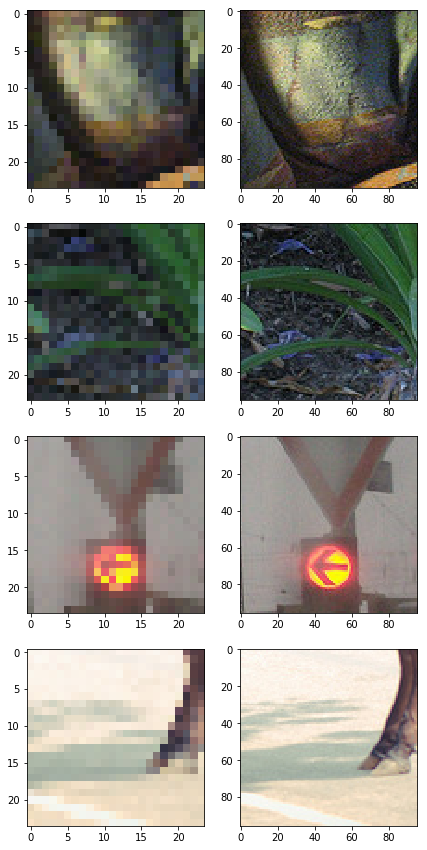

In [14]:
batch_LR, batch_HR = batch_gen.next()
print(batch_LR.shape)
print(batch_HR.shape)

if data_format == 'channels_first':
    batch_LR = np.transpose(batch_LR, (0,2,3,1))
    batch_HR = np.transpose(batch_HR, (0,2,3,1))

# LR| HR 
fig, axes = plt.subplots(4, 2, figsize=(7, 15))
for i in range(4):
    axes[i, 0].imshow(deprocess_LR(batch_LR[i]).astype(np.uint8))
    axes[i, 1].imshow(deprocess_HR(batch_HR[i]).astype(np.uint8))

# Training loop

In [15]:
if os.path.isdir('checkpoints/SRGAN-VGG54/'):
    rmtree('checkpoints/SRGAN-VGG54/')
os.makedirs('checkpoints/SRGAN-VGG54/')

In [16]:
if os.path.isdir('checkpoints/SRGAN-VGG54/BSD100'):
    rmtree('checkpoints/SRGAN-VGG54/BSD100')
os.makedirs('checkpoints/SRGAN-VGG54/BSD100')

In [17]:
num_steps = int(1e5)

print_freq = 50
model_checkpoint_freq = 20000
bsd100_eval_freq = 500

In [ ]:
list_d_loss_fake = []
list_d_loss_real = []
list_g_loss_mse_vgg = []
list_g_loss_cxent = []
start = time()
for step in range(num_steps):
    # plot informations
    if step%print_freq == 0 and step!=0 :
        print('Step {} : '.format(step))
        print("\t d_loss_fake = {:.3f} | d_loss_real = {:.3f}".format(np.mean(list_d_loss_fake[-print_freq::]), 
                                                                   np.mean(list_d_loss_real[-print_freq::])))
        print("\t g_loss_mse_vgg = {:.3f} | g_loss_cxent = {:.3f}".format(np.mean(list_g_loss_mse_vgg[-print_freq::]), 
                                                                   np.mean(list_g_loss_cxent[-print_freq::])))
        print("\t {:.4f} seconds per step\n".format(float(time()-start)/step))
    # make evaluation on BSD100    
    if step%bsd100_eval_freq == 0 and step!= 0:
        BSD100_evaluate(generator, step,
                        filepath='checkpoints/SRGAN-VGG54/BSD100/',
                        directory='data/BSD100/',
                        verbose=1, color_mode='rgb',
                        downscale_factor=4,
                        data_format=data_format,
                        margin=5)
    
    # make checkpoints
    if step%model_checkpoint_freq == 0 and step!=0 :
        discriminator.save_weights('checkpoints/SRGAN-MSE/discrimnator_weights_{}.hdf5'.format(step),
                                   overwrite=True)
        generator.save_weights('checkpoints/SRGAN-MSE/generator_weights_{}.hdf5'.format(step),
                               overwrite=True)
    
    ############################# Train the dicriminator ############################
    discriminator.trainable = True
                                     #On SR images#
    # imageBatch_lr = train_lr[np.random.randint(0,train_lr.shape[0], size=batchSize)]
    batch_LR, batch_HR = batch_gen.next()
    batch_SR = generator.predict(batch_LR)
    # training on noisy labels
    fake_labels = np.random.uniform(0.0, 0.3, size=(batch_SR.shape[0])).astype(np.float32)
    d_loss_fake = discriminator.train_on_batch(batch_SR, fake_labels)
    list_d_loss_fake.append(d_loss_fake)

                                     #On real/HR images#
    batch_LR, batch_HR = batch_gen.next()
    # training on noisy labels
    real_labels = np.random.uniform(0.7, 1.2, size=batch_HR.shape[0]).astype(np.float32)
    d_loss_real = discriminator.train_on_batch(batch_HR, real_labels)
    list_d_loss_real.append(d_loss_real)
    
    
    ############################# Train the generator  ############################
    discriminator.trainable = False
    # index = np.random.randint(0,train_lr.shape[0], size=batchSize)
    # imageBatch_lr = train_lr[index]
    # imageBatch_hr = train_hr[index]
    batch_LR, batch_HR = batch_gen.next()
    misleading_labels = np.ones((batch_LR.shape[0], 1), dtype = np.float32)
    g_loss = generator_gan.train_on_batch(batch_LR, [batch_HR, misleading_labels])
    list_g_loss_mse_vgg.append(g_loss[0])
    list_g_loss_cxent.append(g_loss[1])
    

In [ ]:
BSD100_evaluate(generator, step,
                filepath='checkpoints/SRGAN-VGG54/BSD100/',
                directory='data/BSD100/',
                verbose=1, color_mode='rgb', downscale_factor=4)